# Mounting Google Drive

In [ ]:
##### Import data via Google Drive Mount
# from google.colab import drive
# import os
# import sys
# drive.mount("/content/drive")
# os.chdir("/content/drive")

# base_drive = 'Shared drives/TCAV4OCT/'
# os.chdir(base_drive)
#from google.colab import drive
#drive.mount('/gdrive', force_remount=True)

##### Importing data via Google Drive mount
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Loading Train, Val, and Test Data Using Keras ImageDataGenerator

In [ ]:
# Directory Paths
train_data_dir = "/gdrive/My Drive/newCircleData/TrainValTest/"
#val_dir = "/gdrive/My Drive/newCircleData/Val/"
test_data_dir = "/gdrive/My Drive/mapsRedCap_DCH/fullReports/"

#Image dims and training details
img_width = 448
img_height = 448
batch_size = 1
channels = 3
epochs = 50
# nb_train_samples = 395 590
# nb_valid_samples = 145 147
nb_test_samples = 135

#Keras ImageDataGenerator for loading train, val, and test data
from keras.preprocessing.image import ImageDataGenerator

#train_datagen = ImageDataGenerator(rescale=1./255)             
#valid_datagen = ImageDataGenerator(rescale=1./255)    
test_datagen = ImageDataGenerator(rescale=1./255) 

train_datagen = ImageDataGenerator(rescale=1./255,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    #save_to_dir='/gdrive/My Drive/augmentedInceptionTrain/',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    #save_to_dir='/gdrive/My Drive/augmentedInceptionVal/',
    subset='validation') # set as validation data

# train_generator = train_datagen.flow_from_directory(
#     train_dir, 
#     target_size=(img_height, img_width),
#     color_mode="rgb",
#     batch_size=batch_size,
#     class_mode='binary',
#     shuffle=True)   

# valid_generator = valid_datagen.flow_from_directory(
#     val_dir,
#     target_size=(img_height, img_width),
#     color_mode="rgb",
#     batch_size=batch_size,
#     class_mode='binary',
#     shuffle=True) #weight toward one class or another

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

label_map = train_generator.class_indices
print(label_map)

Found 590 images belonging to 2 classes.
Found 147 images belonging to 2 classes.
Found 135 images belonging to 2 classes.
{'G': 0, 'S': 1}


# Building the Model Architecture (Pre-trained ResNet-18 Extracting Features from OCT Dataset) & Training the Model

In [ ]:
#Loading Pretrained ResNet Model and Extracting Features
import numpy as np 
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Softmax, Flatten, Dense, BatchNormalization 
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras import regularizers
import tensorflow as tf
from keras.models import Sequential

from keras import layers

from keras.callbacks import TensorBoard

#from keras.layers import Input, Dense
from keras import layers
from keras import optimizers
from keras.applications import VGG16

#pretrained VGG16 on imagenet, starting to replicate Hassan's work
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_height, img_width, channels))

conv_base.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 448, 448, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 448, 448, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 448, 448, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 224, 224, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 224, 224, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 224, 224, 128)     147584    
______________________________________________________________

In [ ]:
# conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     # if layer.name == 'stage4_unit2_conv1':
#     #     set_trainable = True
#     # if layer.name == 'stage4_unit2_bn2':
#     #     set_trainable = True
#     # if layer.name == 'stage4_unit2_relu2':
#     #     set_trainable = True
#     # if layer.name == 'zero_padding2d_18':
#     #    set_trainable = True
#     if layer.name == 'stage4_unit2_conv2':
#         set_trainable = True
#     if layer.name == 'add_8':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-6),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 14, 14, 512)       14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 118,001,473
Trainable params: 118,001,473
Non-trainable params: 0
________________________________________

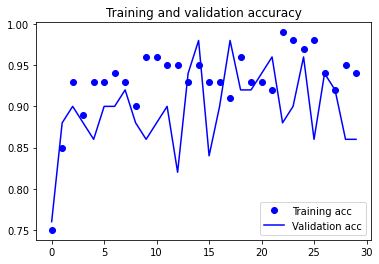

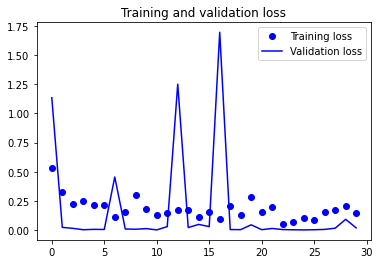

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:

filenames = test_generator.filenames
print(filenames)
nb_samples = len(filenames)


percentCorrect = model.evaluate_generator(test_generator, steps = np.ceil(nb_samples / batch_size))
print(percentCorrect)

['G_fullReports/COL002OD2015-11-13widefieldProbRNFL.png', 'G_fullReports/COL004OD2016-11-07widefieldProbRNFL.png', 'G_fullReports/COL008OD2015-11-16widefieldProbRNFL.png', 'G_fullReports/COL009OS2016-03-08widefieldProbRNFL.png', 'G_fullReports/COL011OD2015-12-01widefieldProbRNFL.png', 'G_fullReports/COL013OD2015-11-19widefieldProbRNFL.png', 'G_fullReports/COL015OD2015-11-05widefieldProbRNFL.png', 'G_fullReports/COL016OS2015-11-05widefieldProbRNFL.png', 'G_fullReports/COL017OS2015-11-06widefieldProbRNFL.png', 'G_fullReports/COL018OS2015-11-16widefieldProbRNFL.png', 'G_fullReports/COL020OS2015-11-24widefieldProbRNFL.png', 'G_fullReports/COL024OS2015-12-04widefieldProbRNFL.png', 'G_fullReports/COL025OD2015-12-10widefieldProbRNFL.png', 'G_fullReports/COL037OD2016-01-11widefieldProbRNFL.png', 'G_fullReports/COL051OD2016-03-10widefieldProbRNFL.png', 'G_fullReports/COL057OD2016-03-22widefieldProbRNFL.png', 'G_fullReports/COL067OS2016-05-02widefieldProbRNFL.png', 'G_fullReports/COL081OD2016-05

In [ ]:
model.save('/gdrive/My Drive/vgg16DenseTranferLearn062920.h5')